In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('/Users/hyunminhong/Documents/Programmings/Python_Jupyter/Projects/titanic/dataset/test.csv')
train = pd.read_csv('/Users/hyunminhong/Documents/Programmings/Python_Jupyter/Projects/titanic/dataset/train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

For simplicity, we divide the training dataset into two subsets; one with categorical variables and the other with continuous variables. 

**cat_var** and **cnt_var** are the lists containing the column names of categorical and continuous variables respectively. 

In [5]:
cat_var = []
cnt_var = []

for col in train.columns:
    if train[col].dtype == 'object' or col == 'PassengerId':
        cat_var.append(col)
    else:
        cnt_var.append(col)

In [6]:
print(cat_var, cnt_var, sep = '\n\n') # check if the partition worked well

['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [7]:
train_cnt = train[cnt_var] # train_cnt is the dataframe with continuous variables
train_cat = train[cat_var] # train_cnt is the dataframe with categorical variables

train_cnt.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


# Explore continuous features

In [8]:
train_cnt.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train_cnt.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


From the above correlation table, we observe that 'Survived' has (relatively) high correlation with 'Pclass' and 'Fare'. Though note that 'Pclass' is also highly correlated with 'Fare', which can trigger a multicollinearity problem. 

Desirably, we want to prevent multicollinearity due to the following issues:
1.  Multicollinearity generates high variance of the estimated coefficients and hence, the coefficient estimates corresponding to those interrelated explanatory variables will not be accurate in giving us the actual picture. They can become very sensitive to small changes in the model;
2. Consecutively the t-ratios for each of the individual slopes might get impacted leading to insignificant coefficients. It is also possible that the adjusted R squared for a model is pretty good and even the overall F-test statistic is also significant but some of the individual coefficients are statistically insignificant. This scenario can be a possible indication of the presence of multicollinearity as multicollinearity affects the coefficients and corresponding p-values, but it does not affect the goodness-of-fit statistics or the overall model significance.



In [10]:
train_cnt.groupby('Pclass')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


In [11]:
def describe_cnt_feature(feature):
    print('\n*** Results for {} ***'.format(feature))
    print(train_cnt.groupby('Survived')[feature].describe())
    print(ttest(feature))
    
def ttest(feature):
    survived     = train_cnt[train_cnt['Survived'] == 1][feature]
    not_survived = train_cnt[train_cnt['Survived'] == 0][feature]
    tstat, p_val = stats.ttest_ind(survived, not_survived, equal_var = False, nan_policy = 'omit')
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat, p_val))

In [12]:
for col in cnt_var:
    describe_cnt_feature(col)


*** Results for Survived ***
          count  mean  std  min  25%  50%  75%  max
Survived                                           
0         549.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1         342.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
t-statistic: inf, p-value: 0.0
None

*** Results for Pclass ***
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  2.531876  0.735805  1.0  2.0  3.0  3.0  3.0
1         342.0  1.950292  0.863321  1.0  1.0  2.0  3.0  3.0
t-statistic: -10.3, p-value: 2.91e-23
None

*** Results for Age ***
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0
t-statistic: -2.0, p-value: 0.0412
None

*** Results for SibSp ***
          count      mean       std  min  25%  

From the above, we observe the following:
1. the differences between survived and non-survived groups in 'Pclass' and 'Fare' are statistically significant; 
2. the difference between survived and non-survived groups in 'SibSp' is not statistically significant, i.e., 'SibSip' does not give much information to predict the survival.

In [13]:
# in order to check whether the missing values in 'Age' is significant, we can have a look at the following
train_cnt.groupby(train_cnt['Age'].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


To me (at least), there is no significant heap between two groups (missing values and existing values in 'Age'). Hence, we can simply drop the missing values. 

# Plot continuous features

In [14]:
def overlaid_histogram(feature, ax):
    survived     = list(train_cnt[train_cnt['Survived'] == 1][feature].dropna())
    not_survived = list(train_cnt[train_cnt['Survived'] == 0][feature].dropna())
    
    xmin  = min(min(survived), min(not_survived))
    xmax  = max(max(survived), max(not_survived))
    width = (xmax - xmin)/40
    
    sns.distplot(survived, color = 'r', kde = False, bins = np.arange(xmin, xmax, width),
                 label = 'Not survived', ax = ax)
    sns.distplot(not_survived, color = 'b', kde = False, bins = np.arange(xmin, xmax, width), 
                 label = 'Survived', ax = ax)
    
    ax.set_title('Overlaid histogram for {}'.format(feature))

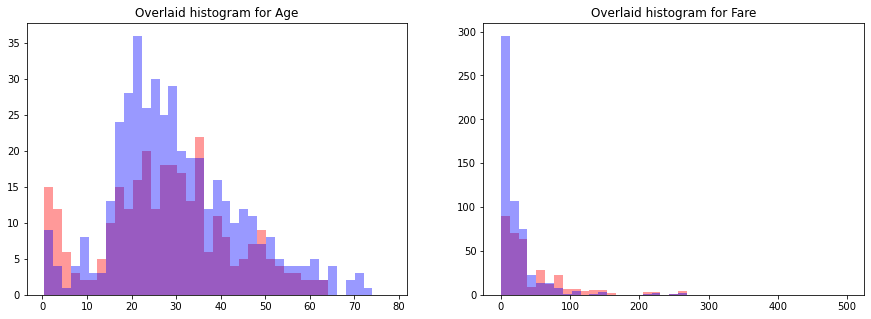

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))

overlaid_histogram('Age', ax = ax[0])
overlaid_histogram('Fare', ax = ax[1])
plt.show()

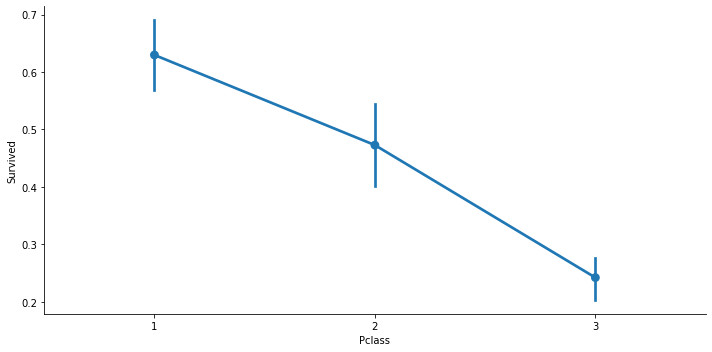

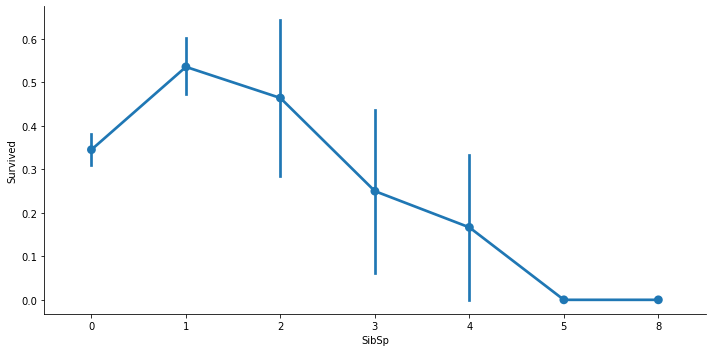

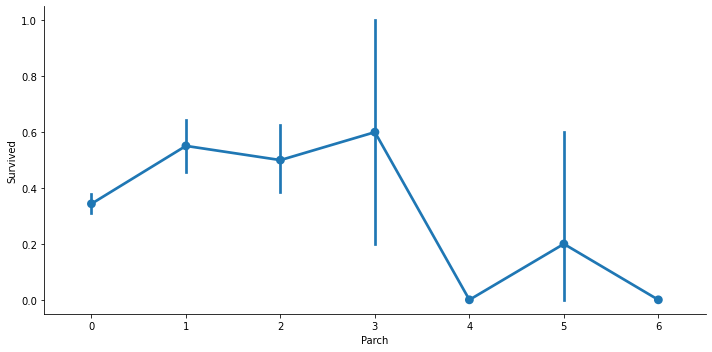

In [16]:
# generate categorical plots for ordinal features
for feature in ['Pclass', 'SibSp', 'Parch']:
    sns.catplot(x = feature, y = 'Survived', data = train_cnt, kind = 'point', aspect = 2)
    plt.ylim = (0,1)

# Explore categorical features

In [17]:
train_cat = train[['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

train_cat.head()

,Survived,Name,Sex,Ticket,Cabin,Embarked
0,0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,1,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,0,"Allen, Mr. William Henry",male,373450,NaN,S


In [18]:
for col in train_cat.columns:
    print('{}: {} unique values'.format(col, len(train_cat[col].unique())))

Survived: 2 unique values
Name: 891 unique values
Sex: 2 unique values
Ticket: 681 unique values
Cabin: 148 unique values
Embarked: 4 unique values


In [19]:
train_cat.groupby('Sex')['Survived'].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [20]:
train_cat.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

From the above, we conclude that $74\%$ of females survived and $19\%$ of males survived, which is significantly different. However, with respect to 'Embarked', there is no significant difference among 'Embarked'.

## Are missing values random?

In [21]:
train_cat.isnull().sum()

Survived      0
Name          0
Sex           0
Ticket        0
Cabin       687
Embarked      2
dtype: int64

In [22]:
train_cat.groupby(train_cat['Cabin'].isnull()).mean()

,Survived
Cabin,
False,0.666667
True,0.299854


Unlike 'Age', the missing values in 'Cabin' do not seem random. Hence, we can add a new variable indicating a person **without** a cabin by assuming that missing values in 'Cabin' are people without a cabin. 

In [23]:
train_cat['Ticket'].value_counts()

1601         7
CA. 2343     7
347082       7
CA 2144      6
347088       6
            ..
347061       1
386525       1
A/5 21171    1
36866        1
345778       1
Name: Ticket, Length: 681, dtype: int64

There is no signal from 'Ticket', hence we will drop this column before modelling. To extract the titles out of the given names, we can do the following.

In [24]:
train_cat['Title'] = train_cat['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())

In [25]:
train_cat.head()

,Survived,Name,Sex,Ticket,Cabin,Embarked,Title
0,0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,Mrs
2,1,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,Mrs
4,0,"Allen, Mr. William Henry",male,373450,NaN,S,Mr


In [26]:
train_cat.pivot_table('Survived', index = ['Sex', 'Title'], aggfunc = ['count', 'mean'])

count      mean
                    Survived  Survived
Sex    Title                          
female Dr                  1  1.000000
       Lady                1  1.000000
       Miss              182  0.697802
       Mlle                2  1.000000
       Mme                 1  1.000000
       Mrs               125  0.792000
       Ms                  1  1.000000
       the Countess        1  1.000000
male   Capt                1  0.000000
       Col                 2  0.500000
       Don                 1  0.000000
       Dr                  6  0.333333
       Jonkheer            1  0.000000
       Major               2  0.500000
       Master             40  0.575000
       Mr                517  0.156673
       Rev                 6  0.000000
       Sir                 1  1.000000

In [27]:
train_cat['Title_simple'] = train_cat['Title'].apply(lambda x : x if x in ['Master', 'Mr', 'Miss', 'Mrs'] else 'Other')
train_cat['Cabin_ind'] = np.where(train_cat['Cabin'].isnull(), 0, 1)

train_cat.head()

,Survived,Name,Sex,Ticket,Cabin,Embarked,Title,Title_simple,Cabin_ind
0,0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S,Mr,Mr,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C,Mrs,Mrs,1
2,1,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S,Miss,Miss,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S,Mrs,Mrs,1
4,0,"Allen, Mr. William Henry",male,373450,NaN,S,Mr,Mr,0


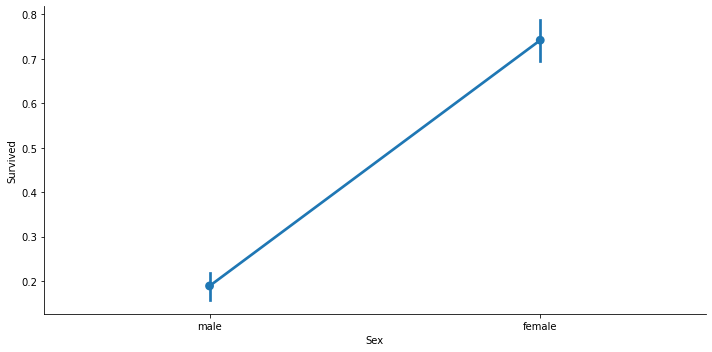

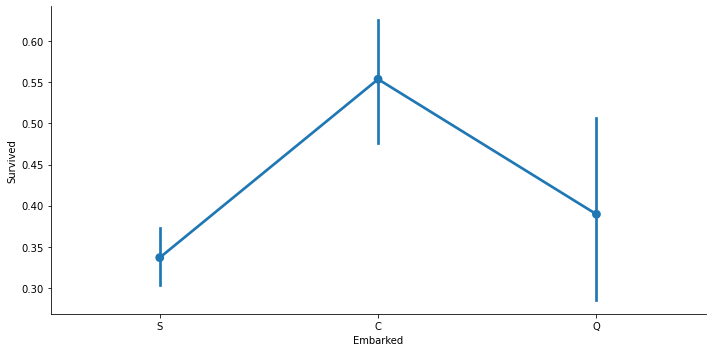

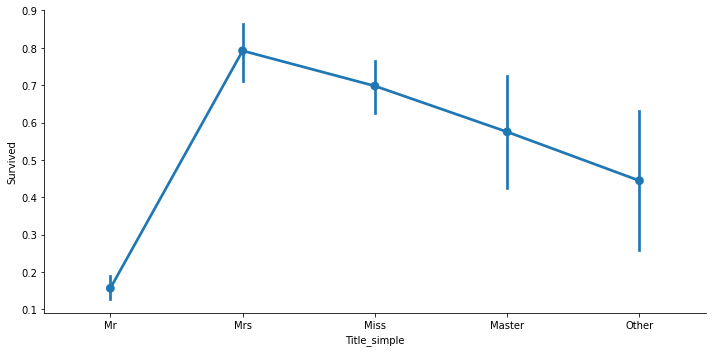

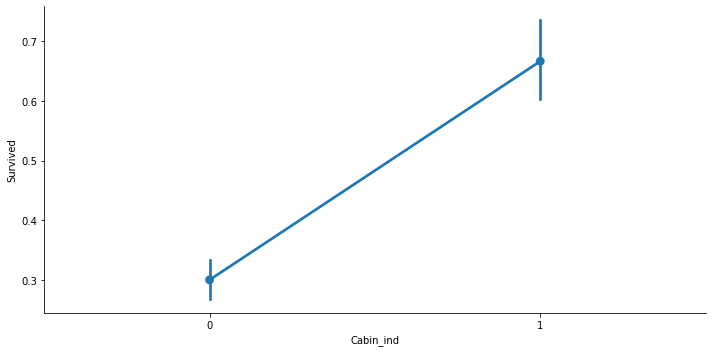

In [28]:
# generate categorical plots for ordinal features
for feature in ['Sex', 'Embarked', 'Title_simple', 'Cabin_ind']:
    sns.catplot(x = feature, y = 'Survived', data = train_cat, kind = 'point', aspect = 2)
    plt.ylim = (0,1)

In [29]:
train_cat.pivot_table('Survived', index = 'Cabin_ind', columns = 'Embarked', aggfunc = ['count', 'mean'])

count               mean                    
Embarked      C   Q    S         C         Q         S
Cabin_ind                                             
0            99  73  515  0.414141  0.383562  0.266019
1            69   4  129  0.753623  0.500000  0.620155

# Dealing with missing values

There are three primary ways to deal with missing values:
1. Replace by the median or mean of the feature
2. Model that feature to predict the missing values
3. Assign it some default value (e.g., Other or -999)

In [30]:
print(train.isnull().sum(), test.isnull().sum(), sep = '\n\n')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Recall that missing values of 'Age' and 'Embaked' are random, i.e., have no pattern in it. Hence, we can fill the missing values with the mean value of the ages. 

In [34]:
train['Age'] = train['Age'].fillna(train['Age'].mean())
test['Age'] = test['Age'].fillna(test['Age'].mean())

test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

train['Embarked'] = train['Embarked'].fillna('O')

train['Title'] = train['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())
test['Title'] = test['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())

train['Cabin_ind'] = np.where(train['Cabin'].isnull(), 0, 1)
test['Cabin_ind'] = np.where(test['Cabin'].isnull(), 0, 1)

train = train.drop(['Name', 'Cabin', 'Ticket'], axis = 1)
test = test.drop(['Name', 'Cabin', 'Ticket'], axis = 1)



In [42]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Cabin_ind
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,0
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,1
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,0
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,1
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,0


In [43]:
print(train.isnull().sum(), test.isnull().sum(), sep = '\n\n')

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
Cabin_ind      0
dtype: int64

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
Cabin_ind      0
dtype: int64


# Tranform skewed features

In [44]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
Title           object
Cabin_ind        int64
dtype: object

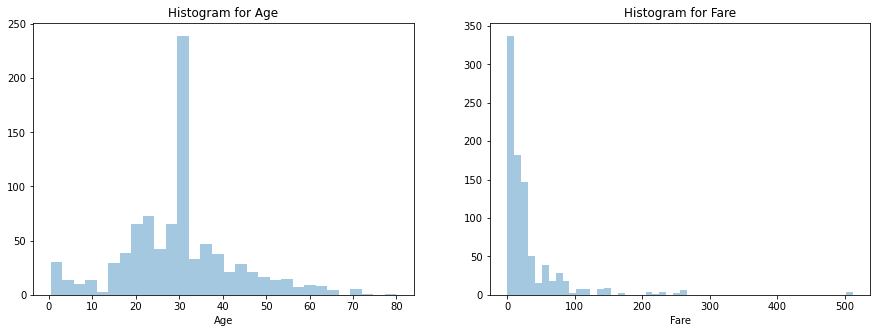

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
i = 0

for col in ['Age', 'Fare']:
    sns.distplot(train[col], kde = False, ax = ax[i])
    ax[i].set_title('Histogram for {}'.format(col))
    i += 1

We can see from the histogram for 'Fare' that the distribution of 'Fare' is skewed. To transform this data, we can use **Box-Cox power transformation**. Of course, our goal is to transform the feature so that the distribution becomes closer to the normal distribution.

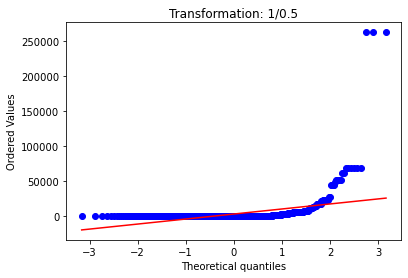

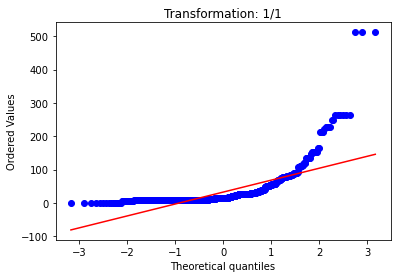

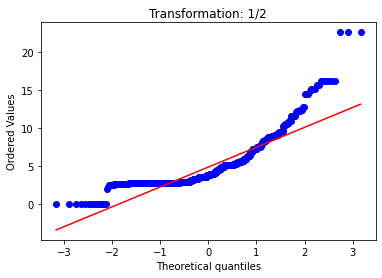

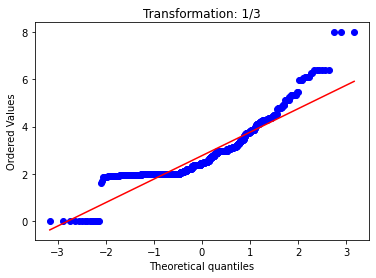

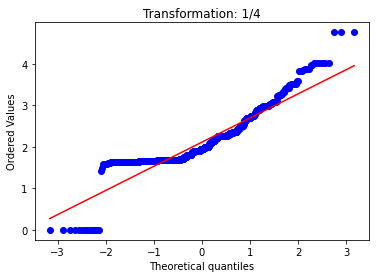

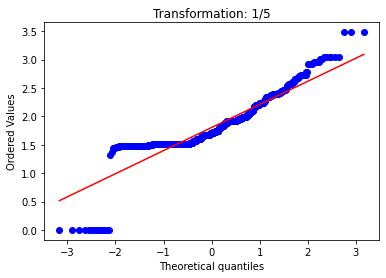

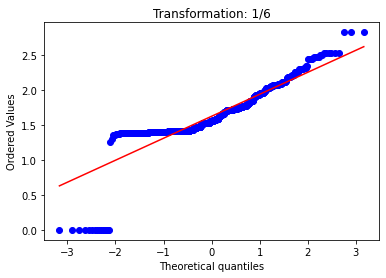

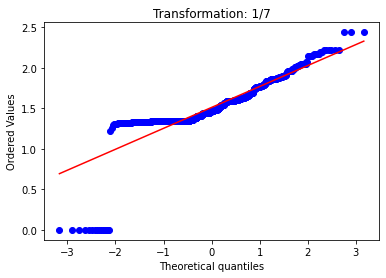

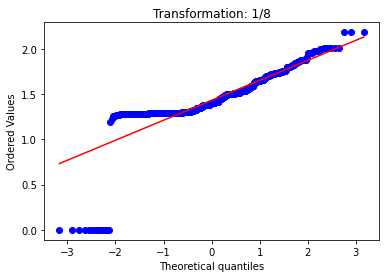

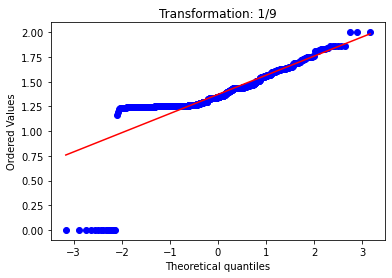

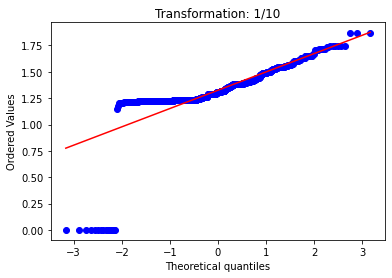

In [47]:
for i in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    temp_data = train['Fare']**(1/i)
    stats.probplot(temp_data, dist = 'norm', plot = plt)
    plt.title('Transformation: 1/{}'.format(i))
    plt.show()

We can see from the above qq-plot, transformation with power of $\frac{1}{5}$ is close enough to theoretical normal distribution. Hence, we transform 'Fare' into $\text{Fare}^{1/5}$.

In [50]:
train['Fare_transform'] = train['Fare'].apply(lambda x : x**(1/5))
test['Fare_transform'] = test['Fare'].apply(lambda x : x**(1/5))

train = train.drop('Fare', axis = 1)
test = test.drop('Fare', axis = 1)

In [51]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Cabin_ind,Fare_transform
0,1,0,3,male,22.0,1,0,S,Mr,0,1.486167
1,2,1,1,female,38.0,1,0,C,Mrs,1,2.347457
2,3,1,3,female,26.0,0,0,S,Miss,0,1.512864
3,4,1,1,female,35.0,1,0,S,Mrs,1,2.213191
4,5,0,3,male,35.0,0,0,S,Mr,0,1.517606


# Convert categorical features into numerical features

In [52]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Cabin_ind,Fare_transform
0,1,0,3,male,22.0,1,0,S,Mr,0,1.486167
1,2,1,1,female,38.0,1,0,C,Mrs,1,2.347457
2,3,1,3,female,26.0,0,0,S,Miss,0,1.512864
3,4,1,1,female,35.0,1,0,S,Mrs,1,2.213191
4,5,0,3,male,35.0,0,0,S,Mr,0,1.517606


In [54]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Cabin_ind,Fare_transform
0,892,3,male,34.5,0,0,Q,Mr,0,1.509188
1,893,3,female,47.0,1,0,S,Mrs,0,1.475773
2,894,2,male,62.0,0,0,Q,Mr,0,1.574861
3,895,3,male,27.0,0,0,S,Mr,0,1.540028
4,896,3,female,22.0,1,1,S,Mrs,0,1.651554


In [55]:
from sklearn.preprocessing import LabelEncoder 

for col in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    # if there are remaining NaN values, we use le.fit_transform(train[feature].astype(str))
    
for col in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])
    # if there are remaining NaN values, we use le.fit_transform(train[feature].astype(str))

In [58]:
train = train.drop('PassengerId', axis = 1)
test = test.drop('PassengerId', axis = 1)

In [59]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Cabin_ind,Fare_transform
0,0,3,1,22.0,1,0,3,11,0,1.486167
1,1,1,0,38.0,1,0,0,12,1,2.347457
2,1,3,0,26.0,0,0,3,8,0,1.512864
3,1,1,0,35.0,1,0,3,12,1,2.213191
4,0,3,1,35.0,0,0,3,11,0,1.517606


In [60]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Cabin_ind,Fare_transform
0,3,1,34.5,0,0,1,5,0,1.509188
1,3,0,47.0,1,0,2,6,0,1.475773
2,2,1,62.0,0,0,1,5,0,1.574861
3,3,1,27.0,0,0,2,5,0,1.540028
4,3,0,22.0,1,1,2,6,0,1.651554


# Modelling

In [61]:
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)
X_test  = test

## Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

rfc.score(X_train, y_train)
acc_random_forest = round(rfc.score(X_train, y_train) * 100, 2)

# Print score
print(round(acc_random_forest,2,), "%")

98.77 %


In [83]:
submission = pd.read_csv('/Users/hyunminhong/Documents/Programmings/Python_Jupyter/Projects/titanic/dataset/gender_submission.csv')
submission['Survived'] = y_pred
submission.to_csv('submission.csv', index = False)